In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sc2ts
import nb_utils

In [2]:
data_dir = Path("../data")

In [3]:
recomb_file = data_dir / "recombinants.csv"
df = pd.read_csv(recomb_file)

assert "k1000_num_mutations" in df.columns  # check we have the altered dataframe

# Temporary hack until we can check that we should just add 1 to the run length
if df.max_run_length.min() == 0:
    df["max_run_length"] += 1

ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

In [4]:
df

,recombinant,descendants,sample,sample_id,sample_pango,interval_left,interval_right,num_mutations,date_added,group_id,...,diffs,max_run_length,max_runlength_3sep,likely_artifactual,k4_num_mutations,k1000_num_mutations,num_mutations_averted,Viridian_amplicon_scheme,Platform,Artic_primer_version
0,1530,1,1529,ERR4437465,B.1.157,8783,13617,2,2020-03-22,052b938d3189a1c873abd3ffd894e4c6,...,13,1,1,False,2,7,5,COVID-ARTIC-V3,ILLUMINA,3
1,22500,1,22499,ERR4638271,B.1.1.217,26528,26714,2,2020-07-23,96ae2d6491a4e2d9432c231e6f2bb7a0,...,18,3,3,False,2,6,4,COVID-ARTIC-V3,ILLUMINA,3
2,26465,54,26464,ERR4615866,B.1.221,15325,21855,1,2020-08-24,dccf6a6ff6f85d67cdd5a7e5c0e5d758,...,14,1,1,False,1,6,5,COVID-ARTIC-V3,ILLUMINA,3
3,27003,3,27002,ERR4671078,B.1.160,22993,25563,2,2020-08-26,0c768f9bb44f8c5d4daf59582c6c9a16,...,26,3,1,False,2,14,12,COVID-ARTIC-V3,OXFORD_NANOPORE,3
4,28379,3,28378,SRR21719160,B.1.426,6542,9515,0,2020-09-02,d856a9a4583881e765e24caeb4533948,...,22,1,1,False,0,4,4,COVID-ARTIC-V3,ILLUMINA,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1430261,1,1430260,ERR10839848,CH.1.1,19327,20741,2,2023-01-23,d5ca15babe3403d4d5764e614d8cf68f,...,44,2,1,False,2,16,14,COVID-ARTIC-V4.1,ILLUMINA,4.1alt
925,1430452,1,1430451,SRR23358540,CH.1.1,9867,12160,1,2023-01-23,b7c8e0260ee65249105de96d2a5c50e3,...,47,4,1,False,1,12,11,COVID-ARTIC-V4.1,ILLUMINA,.
926,1431988,1,1431987,ERR10931828,CH.1.1,19887,21811,2,2023-01-29,efa2dbff2716ef08d00943f0d5c83395,...,11,1,1,False,2,6,4,COVID-ARTIC-V4.1,ILLUMINA,4.1alt
927,1432902,2,1432901,ERR10921923,BY.1.1,20742,21767,3,2023-02-02,ef73940c5b9a228b0c1ab15502a128dd,...,54,4,1,False,3,18,15,COVID-ARTIC-V4.1,ILLUMINA,.


In [5]:
# Check which max run length values are present.
np.unique(df.max_run_length.values)

array([ 1,  2,  3,  4,  5,  6,  8,  9, 14])

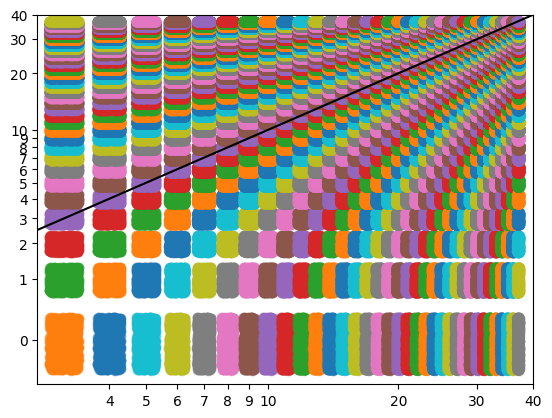

In [6]:
# Check on the amount of jitter needed
# The may not be obvious on a log scale
jitter1 = np.random.uniform(-0.3, 0.3, 1000)
jitter2 = np.random.uniform(-0.3, 0.3, 1000)

x = range(4, 39)
y = range(0, 39)

for xx in x:
    for yy in y:
        plt.scatter(
            [xx + jj for jj in jitter1],
            [yy + jj for jj in jitter2],
            alpha=0.5,
        )

plt.xscale("log")
plt.yscale("log")
plt.minorticks_off()
plt.plot([0.1, 100], [0.1, 100], c="black")
plt.xlim([3.5, 40])
plt.ylim([0.6, 40])
yticks = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 21, 31, 41]
xticks = [5, 6, 7, 8, 9, 10, 11, 21, 31, 41]
plt.xticks(ticks = xticks, labels = [t-1 for t in xticks])
plt.yticks(ticks = yticks, labels = [t-1 for t in yticks])
plt.show()

In [7]:
all(df.num_mutations == df.k4_num_mutations)

True

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


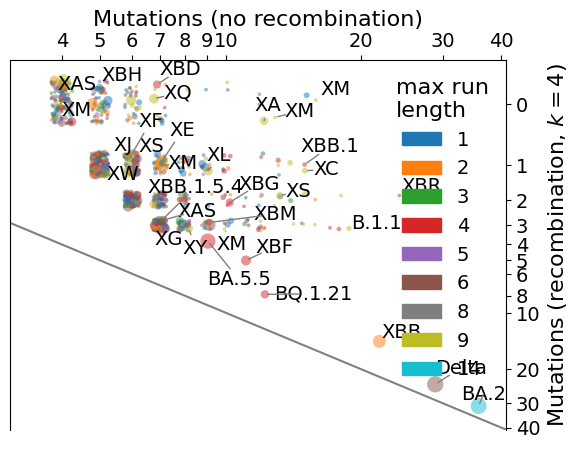

In [8]:
import adjustText

# jitter1 = np.random.lognormal(0, 0.02, len(strainsinfo))
# jitter2 = np.random.lognormal(0, 0.05, len(strainsinfo))

def draw_averted_scatterplot(df, ax, jitter_seed=2):
    np.random.seed(jitter_seed)
    jitter1 = np.random.uniform(-0.25, 0.25, len(df))
    jitter2 = np.random.uniform(-0.25, 0.25, len(df))
    
    colorpal = np.array([
        "#000000",  # 0
        "#1F77B4",  # 1
        "#FF7F0E",  # 2
        "#2CA02C",  # 3
        "#D62728",  # 4
        "#9467BD",  # 5
        "#8C564B",  # 6
        "#E377C2",  # 7
        "#7F7F7F",  # 8
        "#BCBD22",  # 9
        "#000000",  # 10
        "#000000",  # 11
        "#000000",  # 12
        "#000000",  # 13
        "#17BECF",  # 14
    ])
    patches = []
    for i, color in enumerate(colorpal):
        if i in df.max_run_length.values:
            patches.append(mpatches.Patch(color=color, label=str(i)))
    
    x = df.k1000_num_mutations
    y = df.k4_num_mutations
    
    ax.scatter(
        (1 + x) + jitter1, 
        (1 + y) + jitter2, 
        alpha=0.5, 
        s=10 * (np.log(df.descendants + 1)),
        c=colorpal[np.minimum(df.max_run_length, len(colorpal) - 1)],
        edgecolors="none",
    )
    ax.legend(
        handles=patches,
        title="max run\nlength",
        title_fontsize=16,
        fontsize=14,
        loc="upper right",
        frameon=False,
    )
    ax.set_xlabel("Mutations (no recombination)", fontsize=16)
    ax.set_ylabel("Mutations (recombination, $k=4$)", fontsize=16)
    
    texts = []
    for i, (xx, yy, row) in enumerate(zip(x, y, df.itertuples())):
        label=str(row.sample_pango)
        if label == "B.1.617.2":
            label = "Delta"  # hack the label for clarity
        if label.startswith("X"):
            texts.append(ax.text((1 + xx) + jitter1[i], (1 + yy) + jitter2[i], label, fontsize=14))
        elif yy >= 4 or xx > 18:
            # Pango label will be misleading if only 1 non-identified descendant (e.g. BA.1)
            if row.descendants > 1:
                texts.append(ax.text((1 + xx) + jitter1[i], (1 + yy) + jitter2[i], label, fontsize=14))

    # identified_artifactual = [1030562, 293131, 295320, 293126, 1253364, 1279026, 1338895, 871356, 179752]
    # for i, (xx, yy, re_node, label) in enumerate(zip(x, y, df.recombinant, df.sample_pango)):
    #     if re_node in identified_artifactual:
    #         plt.text((1+xx) + jitter1[i], (1+yy) + jitter2[i], label, c="grey")
    
    ax.plot([0.1, 10, 100], [0.1, 10, 100], c="grey")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(3.9, 42)
    ax.set_ylim(0.6, 42)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.invert_yaxis()
    ax.minorticks_off()
    xticks = [5, 6, 7, 8, 9, 10, 11, 21, 31, 41]
    yticks = [1, 2, 3, 4, 5, 6, 7, 9, 11, 21, 31, 41]
    ax.set_xticks(ticks = xticks, labels = [t - 1 for t in xticks], fontsize=14)
    ax.set_yticks(ticks = yticks, labels = [t - 1 for t in yticks], fontsize=14)
    ax.tick_params(
        axis='x',   # Apply changes to the x-axis
        top=True, # Show ticks on the top side
        labeltop=True,    # Show tick labels on the top side
        bottom=False, # Hide ticks on the bottom side
        labelbottom=False,    # Hide tick labels on the bottom side
    )
    ax.tick_params(
        axis='y',   # Apply changes to the y-axis
        right=True, # Show ticks on the right side
        labelright=True,    # Show tick labels on the right side
        left=False, # Hide ticks on the right side
        labelleft=False,    # Hide tick labels on the right side
    )

    adjustText.adjust_text(
        texts,
        arrowprops=dict(
            relpos=(0.5, 0.0),
            arrowstyle="-",
            color="grey",
            shrinkA=10,
            lw=1,
        ),
        ax=ax,
    )

    return colorpal

# Check it looks OK
draw_averted_scatterplot(df, plt.gca());

In [9]:
import tskit
def copying_table(
    self, node, hide_extra_rows=None, show_base=None, hide_labels=True, show_runlengths=True
):
    """
    Display bases that differ between the parents of a recombination node
    Mostly derived from the _copying_table() function in
    https://github.com/jeromekelleher/sc2ts/blob/main/sc2ts/info.py
    
    Parameters
    ----------
    node : int
        The node ID of the child node. This will be placed in the middle row.
    hide_extra_rows : bool or None
        If True, hide the rows that show the site positions, the reference sequence,
        and the de-novo mutations. If False or None (default), show these rows.
    show_base : bool or None
        If True, show the base at the node. If False, do not plot a character, but
        simply show coloured table cells. If None, show a dash for deletions
        and a dot for non-deleted bases in the child (to help indicate number of bases),
        but otherwise to not show a character.
    hide_labels: bool
        If False or None (default), label the rows with P0, P1, etc. If True, hide these
        row labels.
    show_runlengths : bool  
        If True, show a bar under the copying tables indicating adjacent bases.
    
    """
    def css_cell(allele, col, outline_sides=None, default_border_width=0):
        # function for the cell style - nucleotide colours faded from SNiPit
        css = f"border: {default_border_width}px solid black;  text-align: center; width: 1em;"
        if outline_sides is None:
            outline_sides = []
        elif isinstance(outline_sides, str):
             outline_sides = [outline_sides]
        for side in outline_sides:
            css += f"border{side}: 3px solid black;"
        css += "border-collapse: collapse; background-color:" + col
        return f' style="{css}"'

    def line_cell(show_line):
        if show_line:
            return '<td style="background: white; border-bottom: 3px solid red; "></td>'
        return '<td style="background: white;"></td>'

    def row_lab(txt):
        return "" if hide_labels else f"<th>{txt}</th>"

    def label(allele, default=""):
        if show_base is None:
            return ("<b>–</b>" if allele=="-" else default)
        if show_base:
            return allele
        return ''
        
    edges = tskit.EdgeTable()
    for e in sorted([self.ts.edge(i) for i in np.where(self.ts.edges_child==node)[0]], key=lambda e: e.left):
        edges.append(e)    
    vrl = ' style="writing-mode: vertical-rl; transform: rotate(180deg)"'

    parent_cols = {}
    samples = [node]
    for edge in edges:
        if edge.parent not in parent_cols:
            parent_cols[edge.parent] = len(parent_cols) + 1
            samples.append(edge.parent)

    # Can't have missing data here, so we're OK.
    variants = self.ts.variants(samples=samples, isolated_as_missing=False)
    mutations = self.node_mutations(node)

    positions = []
    ref = []
    runs = []
    parents = [[] for _ in range(len(parent_cols))]
    child = []
    extra_mut = []
    prev_pos = None
    prev_parent_col = None
    for var in variants:
        if len(np.unique(var.genotypes)) > 1:
            pos = int(var.site.position)
            if prev_pos is not None and pos == prev_pos + 1:
                runs[-1] = line_cell(True)
                runs.append(line_cell(True))
            else:
                runs.append(line_cell(False))
            positions.append(f"<td><span{vrl}>{pos}</span></td>")
            ref.append(f"<td>{var.site.ancestral_state}</td>")
            child_allele = var.alleles[var.genotypes[0]]

            edge_index = np.searchsorted(edges.left, pos, side="right") - 1
            parent_col = parent_cols[edges[edge_index].parent]
            is_switch = False if prev_parent_col is None else parent_col != prev_parent_col
            parent_colours = ["#FFF", "#8D8", "#6AD"]
            child_colours = parent_colours.copy()
            child_colours[0] = "#FC0"

            colour_index = set()
            for j in range(1, len(var.genotypes)):
                parent_allele = var.alleles[var.genotypes[j]]
                if parent_allele == child_allele:
                    colour_index.add(j)
            assert len(colour_index) < 2  # Only deal with 2 parents for now
            colour_index = colour_index.pop() if len(colour_index) else 0

            for j in range(1, len(var.genotypes)):
                parent_allele = var.alleles[var.genotypes[j]]
                col=parent_colours[0]
                if parent_allele == child_allele:
                    col = parent_colours[colour_index]
                elif parent_allele == var.site.ancestral_state:
                    col = "#DDD"
                outline_sides = []
                if j == parent_col:
                    outline_sides.append("-top" if j == 1 else "-bottom")
                if is_switch:
                    outline_sides.append("-left")
                css = css_cell(parent_allele, col, outline_sides)
                parents[j - 1].append(f"<td{css}>{label(parent_allele)}</td>")
                
            css = css_cell(
                child_allele,
                child_colours[colour_index],
                outline_sides="-left" if is_switch else None,
                #default_border_width=1  # uncomment to outline child bases with a border
            )
            child.append(f"<td{css}>{label(child_allele, ".")}</td>")
            extra_mut.append(f"<td><span{vrl}>{mutations.get(pos, '')}</span></td>")
            prev_pos = pos
            prev_parent_col = parent_col
    html = ""
    if not hide_extra_rows:
        html += '<tr style="font-size: 70%">' + row_lab("pos") + "".join(positions) + '</tr>'
        html += '<tr>' + row_lab("ref") + "".join(ref) + '</tr>'
    rowstyle = "font-size: 10px; border: 0px; height: 14px"
    html += f'<tr style="{rowstyle}">' + row_lab("P0") + "".join(parents.pop(0)) + '</tr>'
    html += f'<tr style="{rowstyle}">' + row_lab("C") + "".join(child) + '</tr>'
    for i, parent in enumerate(parents):
        html += f'<tr style="{rowstyle}">' + row_lab(f"P{i+1}") + "".join(parent) + '</tr>'
    if show_runlengths:
        html += "<tr style='font-size: 6px; height: 6px'>" + row_lab("") + "".join(runs) + "</tr>"
    if not hide_extra_rows:
        html += '<tr style="font-size: 75%">' + row_lab("mut") + "".join(extra_mut) + "</tr>"

    return f"<table style='border-spacing: 0px'>{html}</table>"


In [10]:
from PIL import Image
import imgkit  # To convert the HTML table to a PNG. Also needs wkhtmltox to be installed
import io

# Define RE nodes for which to show a copying pattern
copying_images = {
    "XA": {'id': 122444},
    "XBB": {'id': 1396207},
    "XZ+": {'id': 964555},
    "Delta": {'id': 200039},
    "BA.2": {'id': 822854},
}

# This loop takes a little time to do the HTML copying pattern table -> PNG conversion
for label, val in copying_images.items():
    img = imgkit.from_string(
        copying_table(ti, val['id'], hide_extra_rows=True, hide_labels=True),
        False,  # return the bytes, rather than saving to file
        options={"width": 2000})
    val['img'] = np.asarray(Image.open(io.BytesIO(img)))

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [11]:
def draw_copying_patterns(copying_images, ax, x_scale=1.45):
    row_pos = [0.3, 0, -0.3]
    copying_images["XA"]["pos"] = [0.0, row_pos[0], x_scale, 1]
    copying_images["XBB"]["pos"] = [0.53, row_pos[0], x_scale, 1]   # Manually adjusted
    copying_images["XZ+"]["pos"] = [0.0, row_pos[1], x_scale, 1]
    copying_images["Delta"]["pos"] = [0.71, row_pos[1], x_scale, 1]  # Manually adjusted
    copying_images["BA.2"]["pos"] = [0.0, row_pos[2], x_scale, 1]
    
    ax.axis("off")
    for label, val in copying_images.items():
        ax_image = ax.inset_axes(val["pos"])
        ax_image.imshow(val["img"])
        ax_image.axis('off')  # Remove axis of the image
        ax_image.text(5, 40, label, fontsize=15, ha="right")

In [12]:
import collections

def draw_averted_barplot(df, ax, colorpal, show_labels=True):
    df["mutations_averted"] = df.k1000_num_mutations - df.k4_num_mutations 
    tot_bc = np.bincount(df.mutations_averted)
    max_h = max(tot_bc) * 1.2
    ax.set_ylim(0, max_h)
    bottom = np.zeros(len(tot_bc))
    labels = collections.defaultdict(set)

    for runlen in np.unique(df.max_run_length):
        sub_df = df[df.max_run_length==runlen]
        bc = np.bincount(sub_df.mutations_averted, minlength=len(tot_bc))
        ax.bar(
            np.arange(len(bc)),
            bc,
            bottom=bottom,
            label=f"run length = {runlen}",
            facecolor=colorpal[np.minimum(runlen, len(colorpal) - 1)]
        )
        for g, rows in sub_df.groupby("num_mutations_averted"):
            for row in rows.itertuples():
                if row.sample_pango.startswith("X"):
                    assert row.max_run_length == runlen
                    labels[g].add((row.sample_pango, row.max_run_length))
        bottom += bc

    for g, label in labels.items():
        if len(label):
            bar_top = tot_bc[g] + max_h * 0.01
            for i, line in enumerate(sorted(label, key=lambda x: (len(x), x))):
                ax.text(
                    x=g - 0.40,
                    y=bar_top + (i + 1) * 33,
                    s=line[0],
                    rotation=0,
                    c=colorpal[np.minimum(line[1], len(colorpal) - 1)],
                    ha="left",
                    va="top",
                    fontsize=13,
                )
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(3, np.max(df["mutations_averted"]) + 1)
    xticks = np.arange(4, np.max(df["mutations_averted"]) + 1)
    ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)
    yticks = np.arange(0, 7) * 100
    ax.set_yticks(ticks=yticks, labels=yticks, fontsize=14)
    ax.set_xlabel("Mutations averted by recombination", fontsize=16)
    ax.set_ylabel("Recombination nodes", fontsize=16)

In [13]:
sc2ts_file = data_dir / "recombinants.csv"
rebar_file = data_dir / "rebar.tsv"
df_sc2ts = pd.read_csv(sc2ts_file).set_index("sample_id")
df_rebar = pd.read_csv(rebar_file, sep="\t").set_index("strain")
dfj = df_sc2ts.join(df_rebar, rsuffix="_rebar")
df_hq = dfj[dfj.max_run_length != 5]

rebar_dir = Path("dataset/rebar")
alias_key_file = rebar_dir / "alias_key.json"
lineage_notes_file = rebar_dir / "lineage_notes.txt"

pangonet = nb_utils.initialise_pangonet(
    alias_key_file=alias_key_file,
    lineage_notes_file=lineage_notes_file,
)

pangonet_dist = []
for i, row in df_hq.iterrows():
    if row["parent_left_pango"] == "Unknown (R)" or \
        row["parent_right_pango"] == "Unknown (R)":
        pangonet_dist.append(-1)
        continue
    if row["parent_left_pango"].startswith("X") or \
        row["parent_right_pango"].startswith("X"):
        pangonet_dist.append(-1)
        continue
    d = nb_utils.get_pangonet_distance(
        pangonet=pangonet,
        label_1=row["parent_left_pango"],
        label_2=row["parent_right_pango"],
    )
    pangonet_dist.append(d)

df_hq = df_hq.assign(pangonet_distance=pangonet_dist)
df_hq.columns

2025-04-18 13:25:18,587 INFO:Creating aliases.
2025-04-18 13:25:18,590 INFO:Creating network.


Index(['recombinant', 'descendants', 'sample', 'sample_pango', 'interval_left',
       'interval_right', 'num_mutations', 'date_added', 'group_id',
       'parent_left', 'parent_left_pango', 'parent_right',
       'parent_right_pango', 'mrca', 't_mrca', 'diffs', 'max_run_length',
       'max_runlength_3sep', 'likely_artifactual', 'k4_num_mutations',
       'k1000_num_mutations', 'num_mutations_averted',
       'Viridian_amplicon_scheme', 'Platform', 'Artic_primer_version',
       'validate', 'validate_details', 'population', 'recombinant_rebar',
       'parents', 'breakpoints', 'edge_case', 'unique_key', 'regions',
       'substitutions', 'genome_length', 'dataset_name', 'dataset_tag',
       'cli_version', 'pangonet_distance'],
      dtype='object')

In [14]:
is_rebar_nonrecomb = df_hq["recombinant_rebar"].isna()
rebar_nonrecomb_averted_muts = df_hq[is_rebar_nonrecomb].num_mutations_averted
rebar_recomb_averted_muts = df_hq[~is_rebar_nonrecomb].num_mutations_averted
rebar_nonrecomb_pangonet_dist = df_hq[is_rebar_nonrecomb].pangonet_distance
rebar_recomb_pangonet_dist = df_hq[~is_rebar_nonrecomb].pangonet_distance

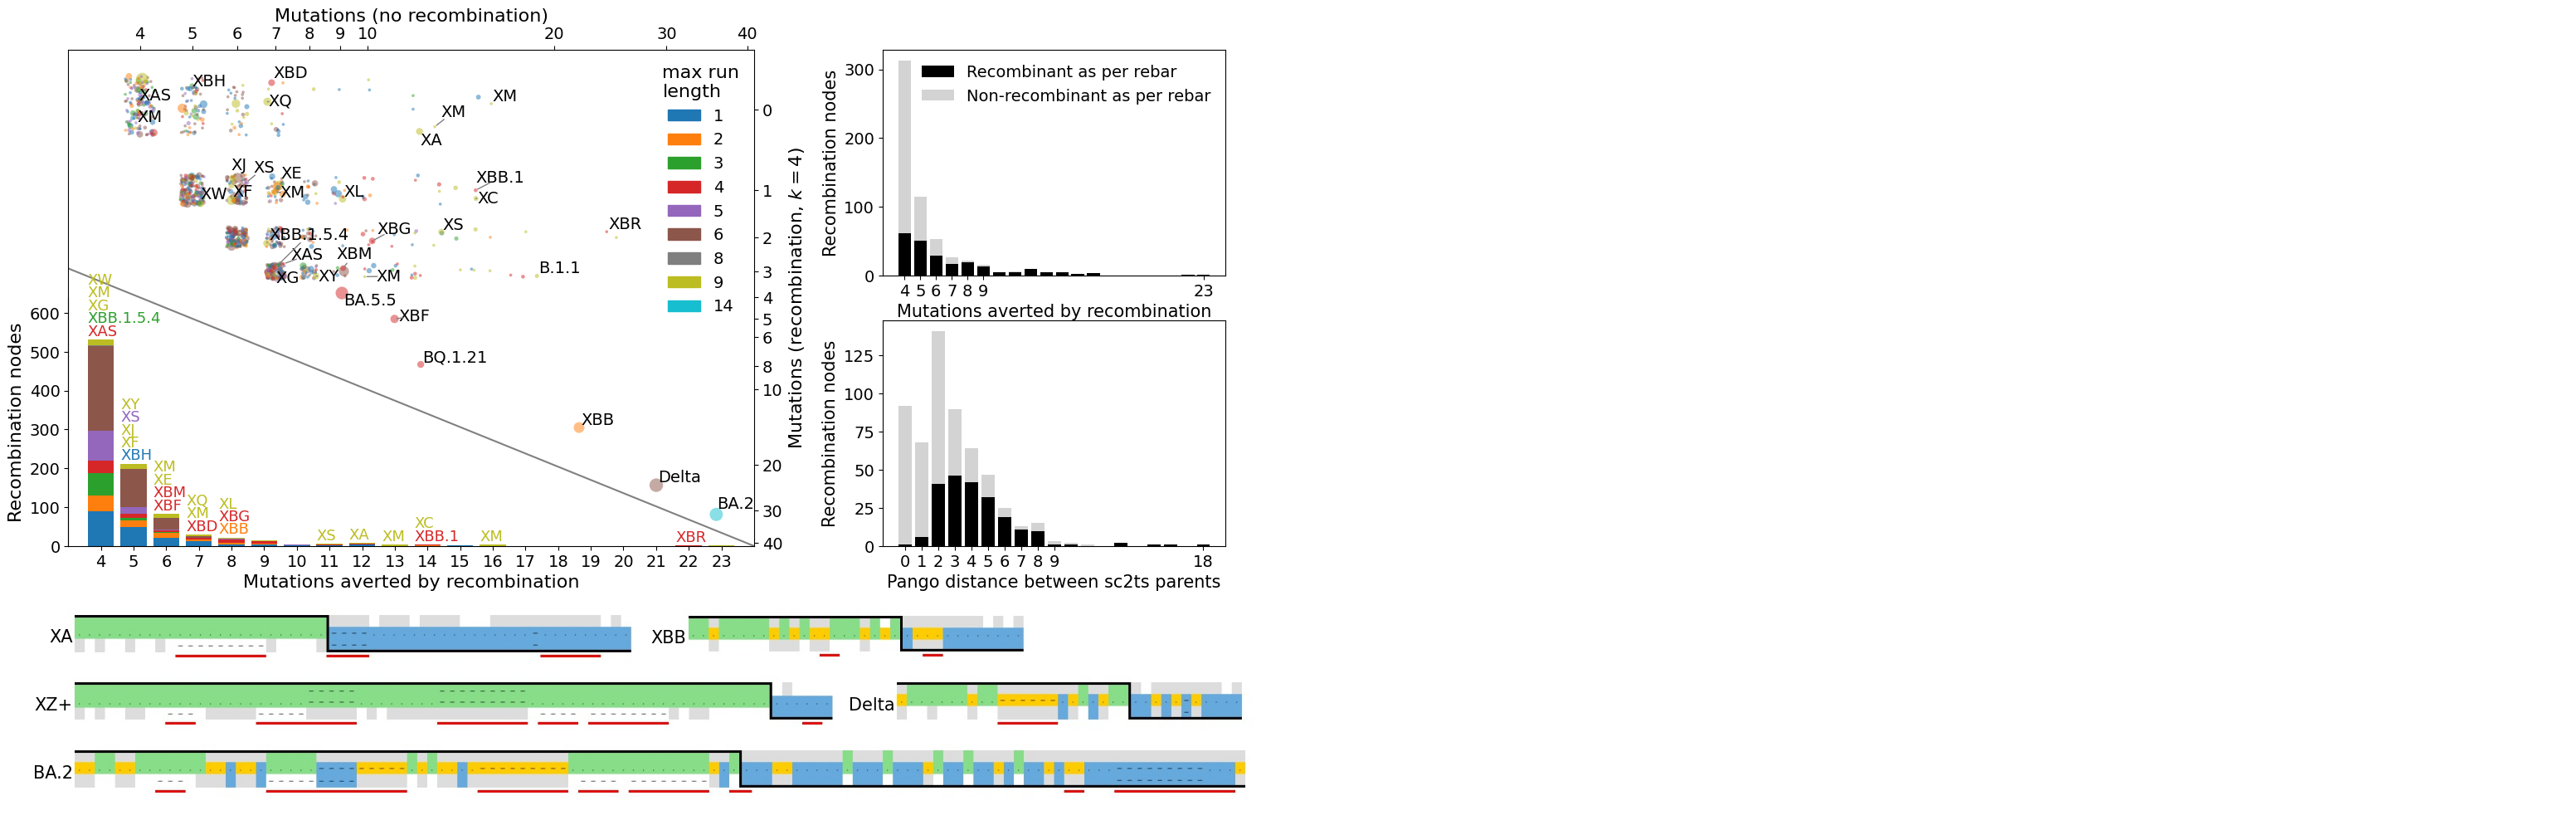

In [15]:
from matplotlib.gridspec import GridSpec

# Set up layout and different subplot axes
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, figure=fig, wspace=0.25, width_ratios=(2, 1))

scatter_ax = fig.add_subplot(gs[0:2, 0])
copypattern_ax = fig.add_subplot(gs[2, :])
hist_averted_muts_ax = fig.add_subplot(gs[0, 1])
hist_pangonet_dist_ax = fig.add_subplot(gs[1, 1])
inset_hist_ax = scatter_ax.inset_axes([0, 0, 1.0, 0.5])
inset_hist_ax.set_facecolor("none")

c_palette = draw_averted_scatterplot(df, scatter_ax, jitter_seed=2) # or try 16
draw_copying_patterns(copying_images, copypattern_ax)
draw_averted_barplot(df, inset_hist_ax, c_palette)

nb_utils.draw_stacked_histogram(
    a=rebar_recomb_averted_muts,
    b=rebar_nonrecomb_averted_muts,
    ax=hist_averted_muts_ax,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='Mutations averted by recombination',
    ylabel='Recombination nodes',
    xlim=[4, 25],
    show_legend=True,
)
hist_averted_muts_ax.tick_params(axis='both', which='major', labelsize=14)
xticks = [4, 5, 6, 7, 8, 9, max(df.mutations_averted)]
hist_averted_muts_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)

nb_utils.draw_stacked_histogram(
    a=rebar_recomb_pangonet_dist,
    b=rebar_nonrecomb_pangonet_dist,
    ax=hist_pangonet_dist_ax,
    alegend='Recombinant as per rebar',
    blegend='Non-recombinant as per rebar',
    xlabel='Pango distance between sc2ts parents',
    ylabel='Recombination nodes',
    xlim=[0, 20],
    show_legend=False,
)
hist_pangonet_dist_ax.tick_params(axis='both', which='major', labelsize=14)
xticks = [x for x in range(10)] + [max(df_hq.pangonet_distance)]
hist_pangonet_dist_ax.set_xticks(ticks=xticks, labels=xticks, fontsize=14)

plt.savefig("Fig3.pdf", format='pdf', dpi=600, transparent=True)